In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS
from sklearn.model_selection import train_test_split

## Reading The Data

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
df = pd.read_csv('/content/drive/MyDrive/Direktori Python/review_tiktok.csv')
df.head()

,Unnamed: 0,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt
0,0,gp:AOqpTOFENoHk7-Xp_qYh_rRQlXXy9_io4YA7PKweeQ9...,Syamil Mohammad,https://play-lh.googleusercontent.com/a-/AOh14...,The best,5,0,20.8.4,2021-08-29 21:40:38,NaN,NaN
1,1,gp:AOqpTOEQTIcaQfuanys5tAmIFM0NJxHpE7i0v6YRbyE...,Jx Tuason,https://play-lh.googleusercontent.com/a/AATXAJ...,This App Is Cool You Will Watch Tuturial Or Dance,5,0,NaN,2021-08-29 21:37:03,NaN,NaN
2,2,gp:AOqpTOETcrjZdrDoymAwjy_xY6VuXLaYqdoH5BpdzQ7...,Jacky hng,https://play-lh.googleusercontent.com/a-/AOh14...,Love it so much,5,0,20.8.4,2021-08-29 21:35:40,NaN,NaN
3,3,gp:AOqpTOEFOS4QNB99BEi5TCQHtzy4hulrFounZtBOuQL...,Aron Carpio,https://play-lh.googleusercontent.com/a-/AOh14...,idk man,2,0,NaN,2021-08-29 21:35:02,NaN,NaN
4,4,gp:AOqpTOFTcZkPSKZmE6sp3GvfNqA3EtGvgKJKPV3DaII...,xxz gurl,https://play-lh.googleusercontent.com/a/AATXAJ...,@shicexn,5,0,NaN,2021-08-29 21:34:59,NaN,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 686691 entries, 0 to 686690
Data columns (total 11 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Unnamed: 0            686691 non-null  int64 
 1   reviewId              686691 non-null  object
 2   userName              686689 non-null  object
 3   userImage             686691 non-null  object
 4   content               686685 non-null  object
 5   score                 686691 non-null  int64 
 6   thumbsUpCount         686691 non-null  int64 
 7   reviewCreatedVersion  377004 non-null  object
 8   at                    686691 non-null  object
 9   replyContent          6734 non-null    object
 10  repliedAt             6734 non-null    object
dtypes: int64(3), object(8)
memory usage: 57.6+ MB


In [5]:
df.shape

(686691, 11)

In [6]:
df.columns

Index(['Unnamed: 0', 'reviewId', 'userName', 'userImage', 'content', 'score',
       'thumbsUpCount', 'reviewCreatedVersion', 'at', 'replyContent',
       'repliedAt'],
      dtype='object')

In [7]:
# drop unsused columns
df = df.drop(['Unnamed: 0', 'reviewId', 'userName', 'userImage', 'thumbsUpCount',
              'reviewCreatedVersion', 'at', 'replyContent','repliedAt'], axis=1)
df.head()

,content,score
0,The best,5
1,This App Is Cool You Will Watch Tuturial Or Dance,5
2,Love it so much,5
3,idk man,2
4,@shicexn,5


## Data Preprocessing

In [13]:
# Pre-processing steps for data

df['content'] = [re.sub('\s*@\s*\s?', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('\?', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('\_', ' ', str(sent)) for sent in df['content']]

df['content'] = [re.sub('@"[\d-]"', ' ', str(sent)) for sent in df['content']]

# Remove new line characters
df['content'] = [re.sub('\s+', ' ', str(sent)) for sent in df['content']]

# Remove distracting single quotes
df['content'] = [re.sub("\'", " ", str(sent)) for sent in df['content']]

#Converting into lowercase
df['content']=df['content'].str.lower()

# Emojis pattern
def remove_emojis(data):
  emoj= re.compile('['
                u'\U0001F600-\U0001F64F'  # emoticons
                u'\U0001F300-\U0001F5FF'  # symbols & pictographs
                u'\U0001F680-\U0001F6FF'  # transport & map symbols
                u'\U0001F1E0-\U0001F1FF'  # flags (iOS)
                u'\U00002702-\U000027B0'
                u'\U000024C2-\U0001F251'
                u'\U0001f926-\U0001f937'
                u'\U00010000-\U0010ffff'
                u'\u200d'
                u'\u2640-\u2642'
                u'\u2600-\u2B55'
                u'\u23cf'
                u'\u23e9'
                u'\u231a'
                u'\u3030'
                u'\ufe0f'
    ']+', flags=re.UNICODE)
  return re.sub(emoj, '', data)

In [14]:
df['content'] = df['content'].apply(remove_emojis)

In [15]:
df

,content,score
0,the best,5
1,this app is cool you will watch tuturial or dance,5
2,love it so much,5
3,idk man,2
4,shicexn,5
...,...,...
686686,i think only apple can upload the video comple...,2
686687,,5
686688,apps,2
686689,erm i rather use musical.ly becuz for some mob...,2


In [16]:
# Create a function to get the subjectivity
def getSubjectivity(text):
    return TextBlob(text).sentiment.subjectivity

# Create a function to get the polarity
def getPolarity(text):
    return TextBlob(text).sentiment.polarity

# Create two new columns
df['Subjectivity'] = df['content'].apply(getSubjectivity)
df['Polarity'] = df['content'].apply(getPolarity)

# Show the new dataframe
df

,content,score,Subjectivity,Polarity
0,the best,5,0.300000,1.000000
1,this app is cool you will watch tuturial or dance,5,0.650000,0.350000
2,love it so much,5,0.400000,0.350000
3,idk man,2,0.000000,0.000000
4,shicexn,5,0.000000,0.000000
...,...,...,...,...
686686,i think only apple can upload the video comple...,2,0.566667,0.100000
686687,,5,0.000000,0.000000
686688,apps,2,0.000000,0.000000
686689,erm i rather use musical.ly becuz for some mob...,2,0.585714,0.528571


In [17]:
# Create a function to compute the negative, neutral and positive analysis
def getAnalysis(score):
    if score < 0 :
        return 'Negative'
    elif score == 0 :
        return 'Neutral'
    else:
        return 'Positive'

df['Sentiment'] = df['Polarity'].apply(getAnalysis)

# Show the dataframe
df

,content,score,Subjectivity,Polarity,Sentiment
0,the best,5,0.300000,1.000000,Positive
1,this app is cool you will watch tuturial or dance,5,0.650000,0.350000,Positive
2,love it so much,5,0.400000,0.350000,Positive
3,idk man,2,0.000000,0.000000,Neutral
4,shicexn,5,0.000000,0.000000,Neutral
...,...,...,...,...,...
686686,i think only apple can upload the video comple...,2,0.566667,0.100000,Positive
686687,,5,0.000000,0.000000,Neutral
686688,apps,2,0.000000,0.000000,Neutral
686689,erm i rather use musical.ly becuz for some mob...,2,0.585714,0.528571,Positive


## Exploratory Data Analysis

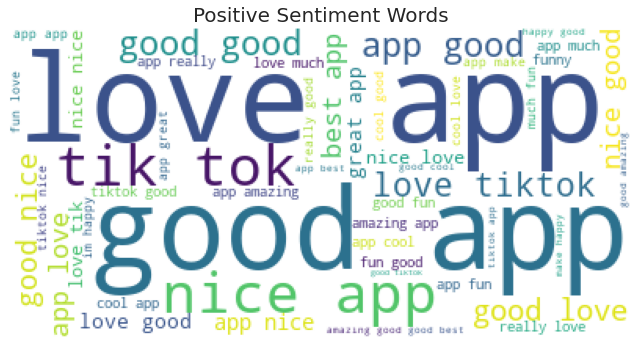

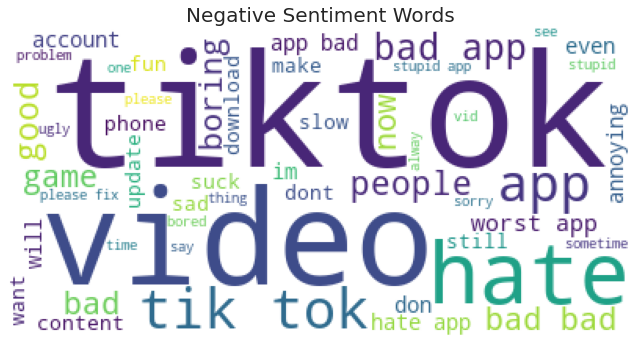

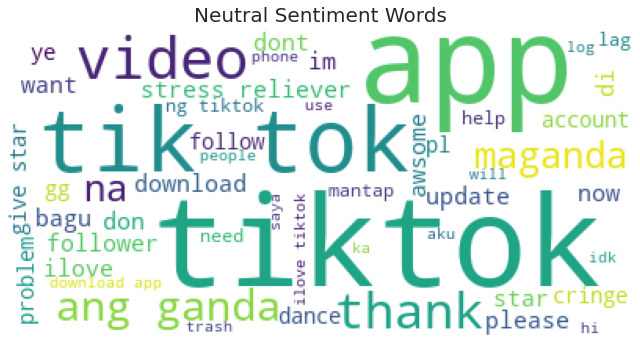

In [18]:
def wordcount_gen(df, category):
    # Combine all reviews
    allWords = " ".join([text for text in df[df.Sentiment==category]['content']])
                          
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', 
                   max_words=50, 
                   stopwords = STOPWORDS)

    # Generate and plot wordcloud
    plt.figure(figsize=(10,10))
    plt.imshow(wc.generate(allWords))
    plt.title('{} Sentiment Words'.format(category), fontsize=20)
    plt.axis('off')
    plt.show()
    
# Positive reviews words
wordcount_gen(df, 'Positive')
     
# Negative reviews words
wordcount_gen(df, 'Negative')
     
# Neutral reviews words
wordcount_gen(df, 'Neutral')

In [19]:
# Get the percentege of positive reviews
previews = df[df.Sentiment == 'Positive']
previews = previews['content']

round((previews.shape[0] / df.shape[0])*100, 2)

62.02

In [20]:
# Get the percentege of negative reviews
previews = df[df.Sentiment == 'Neutral']
previews = previews['content']

round((previews.shape[0] / df.shape[0])*100, 2)

33.05

In [21]:
# Get the percentege of negative reviews
previews = df[df.Sentiment == 'Negative']
previews = previews['content']

round((previews.shape[0] / df.shape[0])*100, 2)

4.93

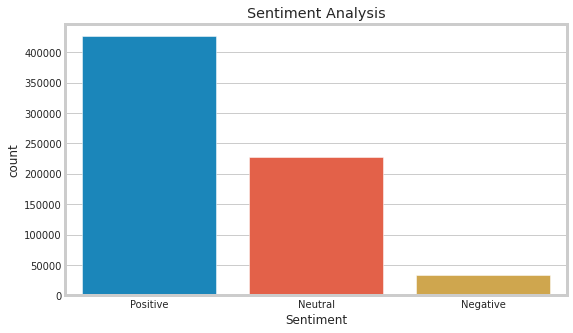

In [22]:
# Plot and visualize the counts
plt.figure(figsize=(8,5))
sns.countplot(x='Sentiment', data=df)
plt.title('Sentiment Analysis')
plt.show()

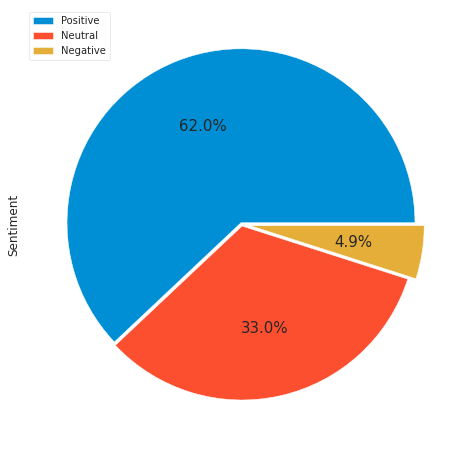

In [23]:
plt.figure(figsize=(8,8))
df['Sentiment'].value_counts().plot(kind='pie',
                                   labels = ['','',''],
                                   autopct='%1.1f%%',
                                   explode = [0.01, 0.01, 0.05],
                                   textprops = {"fontsize":15})
plt.legend(labels=['Positive', 'Neutral', 'Negative'], loc='upper left')
plt.show()

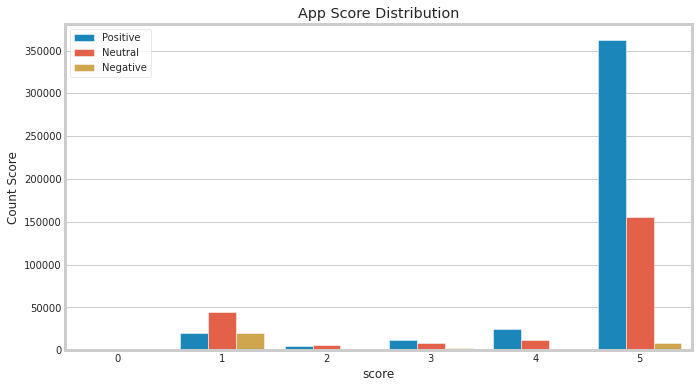

In [24]:
# visualize app score distribution
plt.figure(figsize=(10,6))
sns.countplot(x='score', hue='Sentiment', data = df)
plt.ylabel('Count Score', fontsize= 12)
plt.title('App Score Distribution')
plt.legend(loc='upper left')
plt.show()

## Data Modeling

In [25]:
y = list(df['Sentiment'])
X = list(df['content'])

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

### Create bag of words

In [27]:
from sklearn.feature_extraction.text import CountVectorizer

vocabulary_size = 5000

count_vector = CountVectorizer(max_features=vocabulary_size,
                               preprocessor=lambda x: x,
                               tokenizer=lambda x: x) 
#tfidf_vector = TfidfVectorizer(lowercase=True, stop_words='english')

# Fit the training data
X_train = count_vector.fit_transform(X_train).toarray()

# Transform testing data
X_test = count_vector.transform(X_test).toarray()

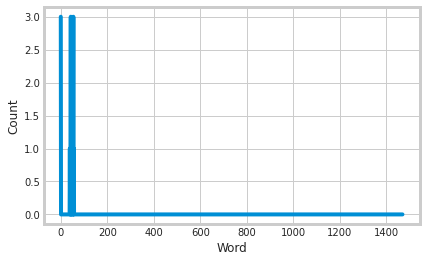

In [28]:
# Plot the BoW feature vector
plt.plot(X_train[2,:])
plt.xlabel('Word')
plt.ylabel('Count')
plt.show()

In [29]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

max_words = 5000
max_len=50

def tokenize_pad_sequences(text):
    '''
    This function tokenize the input text into sequnences of intergers and then
    pad each sequence to the same length
    '''
    # Text tokenization
    tokenizer = Tokenizer(num_words=max_words, lower=True, split=' ')
    tokenizer.fit_on_texts(text)
    # Transforms text to a sequence of integers
    X = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    X = pad_sequences(X, padding='post', maxlen=max_len)
    # return sequences
    return X, tokenizer

print('Before Tokenization & Padding \n', df['content'][0])
X, tokenizer = tokenize_pad_sequences(df['content'])
print('After Tokenization & Padding \n', X[0])

Before Tokenization & Padding 
 the best
After Tokenization & Padding 
 [11 33  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


### Saving Tokenized Data

In [30]:
import pickle

# saving
with open('tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

# loading
with open('tokenizer.pickle', 'rb') as handle:
    tokenizer = pickle.load(handle)

In [31]:
y = pd.get_dummies(df['Sentiment'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)
print('Train Set ->', X_train.shape, y_train.shape)
print('Validation Set ->', X_val.shape, y_val.shape)
print('Test Set ->', X_test.shape, y_test.shape)

Train Set -> (386263, 50) (386263, 3)
Validation Set -> (128755, 50) (128755, 3)
Test Set -> (171673, 50) (171673, 3)


In [32]:
import tensorflow.keras.backend as K

def f1_score(precision, recall):
    ''' Function to calculate f1 score '''
    
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

### Biderectional LSTM Using NN

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import datasets

from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.callbacks import History

from tensorflow.keras import losses

vocab_size = 5000
embedding_size = 32
epochs=20
learning_rate = 0.1
decay_rate = learning_rate / epochs
momentum = 0.8

sgd = SGD(lr=learning_rate, momentum=momentum, decay=decay_rate, nesterov=False)
# Build model
model= Sequential()
model.add(Embedding(vocab_size, embedding_size, input_length=max_len))
model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Bidirectional(LSTM(32)))
model.add(Dropout(0.4))
model.add(Dense(3, activation='softmax'))

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/optimizer_v2.py:356: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  "The `lr` argument is deprecated, use `learning_rate` instead.")


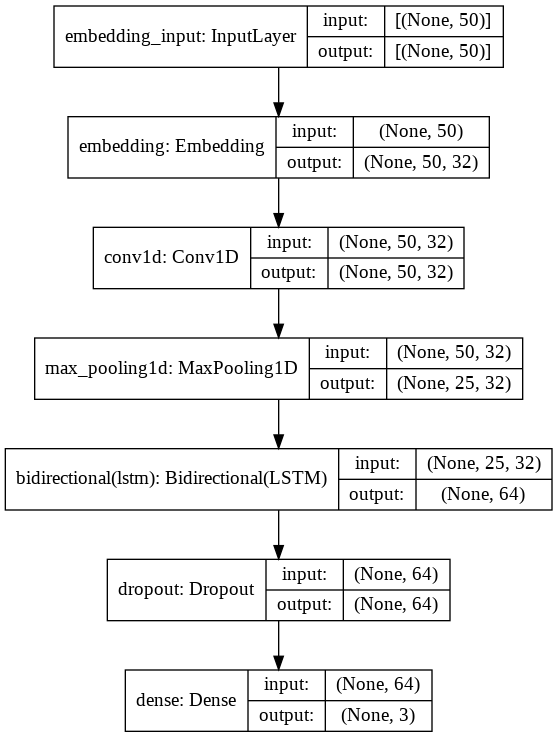

In [34]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

### Model Accuracy & Loss

In [35]:
print(model.summary())

# Compile model
model.compile(loss='categorical_crossentropy', optimizer=sgd, 
               metrics=['accuracy', Precision(), Recall()])

# Train model

batch_size = 64
history = model.fit(X_train, y_train,
                      validation_data=(X_val, y_val),
                      batch_size=batch_size, epochs=epochs, verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 50, 32)            160000    
_________________________________________________________________
conv1d (Conv1D)              (None, 50, 32)            3104      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 25, 32)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                16640     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 3)                 195       
Total params: 179,939
Trainable params: 179,939
Non-trainable params: 0
__________________________________________________

## Evaluate Model

In [36]:
# Evaluate model on the test set
loss, accuracy, precision, recall = model.evaluate(X_test, y_test, verbose=0)
# Print metrics
print('')
print('Accuracy  : {:.4f}'.format(accuracy))
print('Precision : {:.4f}'.format(precision))
print('Recall    : {:.4f}'.format(recall))
print('F1 Score  : {:.4f}'.format(f1_score(precision, recall)))


Accuracy  : 0.9792
Precision : 0.9799
Recall    : 0.9781
F1 Score  : 0.9790


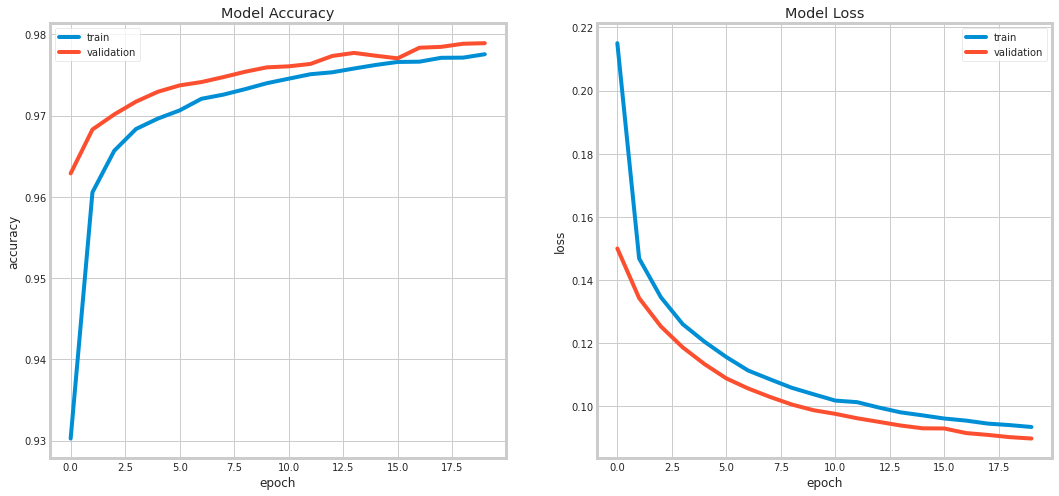

In [38]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(16,8))
    # first plot
    ax[0].plot(history.history['accuracy'])
    ax[0].plot(history.history['val_accuracy'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)

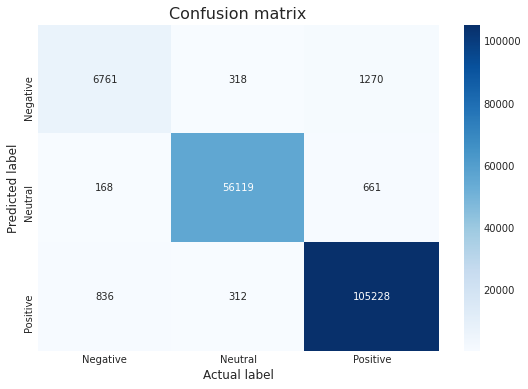

In [39]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    # use model to do the prediction
    y_pred = model.predict(X_test)
    # compute confusion matrix
    cm = confusion_matrix(np.argmax(np.array(y_test),axis=1), np.argmax(y_pred, axis=1))
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
    
plot_confusion_matrix(model, X_test, y_test)

## Try The Model

### Save the model

In [45]:
# Save the model architecture & the weights
model.save('best_model.h5')
print('Best model saved')

Best model saved


### Load the model

In [46]:
from keras.models import load_model

# Load model
model = load_model('best_model.h5')

def predict_class(text):
    
    sentiment_classes = ['Negative', 'Neutral', 'Positive']
    max_len=50
    
    # Transforms text to a sequence of integers using a tokenizer object
    xt = tokenizer.texts_to_sequences(text)
    # Pad sequences to the same length
    xt = pad_sequences(xt, padding='post', maxlen=max_len)
    # Do the prediction using the loaded model
    yt = model.predict(xt).argmax(axis=1)
    # Print the predicted sentiment
    print('The predicted sentiment is', sentiment_classes[yt[0]])

In [47]:
predict_class(['this app is cool you will watch tuturial or dance'])

The predicted sentiment is Positive


In [48]:
predict_class(['so hard to use'])

The predicted sentiment is Negative


In [49]:
predict_class(['book'])

The predicted sentiment is Neutral
